This script helps to plot and analyze kaggle titanic sinking data. First I'm adding the required library.



In [1]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns



from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6




I took help for plotting data from [kaggle datascience tutorial](https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial).

In [4]:
class Helper_Plotter():
    def __init__(self):
        """
        This class helps printing various statistics of the data
        """
    def plot_histograms(self, df , variables , n_rows , n_cols ):
        fig = plt.figure( figsize = ( 16 , 12 ) )
        for i, var_name in enumerate( variables ):
            ax=fig.add_subplot( n_rows , n_cols , i+1 )
            df[ var_name ].hist( bins=10 , ax=ax )
            ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
            ax.set_xticklabels( [] , visible=False )
            ax.set_yticklabels( [] , visible=False )
        fig.tight_layout()  # Improves appearance a bit.
        plt.show()

    def plot_distribution(self, df , var , target , **kwargs ):
        row = kwargs.get( 'row' , None )
        col = kwargs.get( 'col' , None )
        facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
        facet.map( sns.kdeplot , var , shade= True )
        facet.set( xlim=( 0 , df[ var ].max() ) )
        facet.add_legend()

    def plot_categories(self, df , cat , target , **kwargs ):
        row = kwargs.get( 'row' , None )
        col = kwargs.get( 'col' , None )
        facet = sns.FacetGrid( df , row = row , col = col )
        facet.map( sns.barplot , cat , target )
        facet.add_legend()

    def plot_correlation_map(self, df ):
        corr = X.corr()
        _ , ax = plt.subplots( figsize =( 12 , 10 ) )
        cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
        _ = sns.heatmap(
            corr, 
            cmap = cmap,
            square=True, 
            cbar_kws={ 'shrink' : .9 }, 
            ax=ax, 
            annot = True, 
            annot_kws = { 'fontsize' : 12 }
        )

    def describe_more(self, df ):
        var = [] ; l = [] ; t = []
        for x in df:
            var.append( x )
            l.append( len( pd.value_counts( df[ x ] ) ) )
            t.append( df[ x ].dtypes )
        levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
        levels.sort_values( by = 'Levels' , inplace = True )
        return levels

    def plot_variable_importance(self, X , y ):
        tree = DecisionTreeClassifier( random_state = 99 )
        tree.fit( X , y )
        plot_model_var_imp(self, tree , X , y )

    def plot_model_var_imp( model , X , y ):
        imp = pd.DataFrame( 
            model.feature_importances_  , 
            columns = [ 'Importance' ] , 
            index = X.columns 
        )
        imp = imp.sort_values( [ 'Importance' ] , ascending = True )
        imp[ : 10 ].plot( kind = 'barh' )
        print (model.score( X , y ))    
        


Creating Helper objects and load data and X.head() print the upper 5 rows accordingly.


In [6]:
hlp = Helper_Plotter()

train_df = pd.read_csv("../input/train.csv")
test_df    = pd.read_csv("../input/test.csv")

X = train_df.append( test_df , ignore_index = True )


X.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [7]:
X.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


In [10]:
hlp.describe_more(X)

,Datatype,Levels,Variable
8,object,2,Sex
10,float64,2,Survived
2,object,3,Embarked
7,int64,3,Pclass
9,int64,7,SibSp
5,int64,8,Parch
0,float64,98,Age
1,object,186,Cabin
3,float64,281,Fare
11,object,929,Ticket


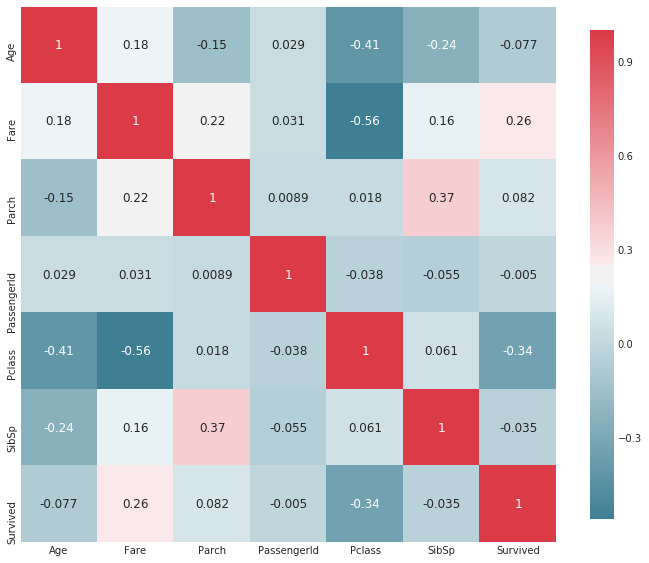

In [11]:
hlp.plot_correlation_map(X)

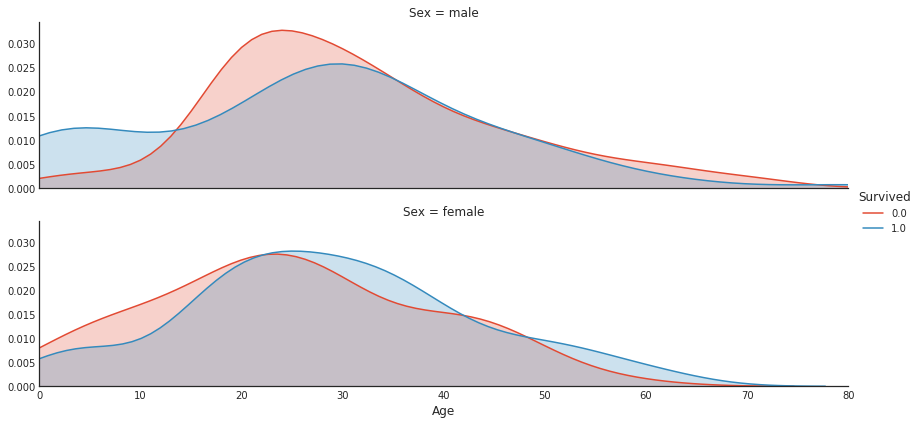

In [13]:
hlp.plot_distribution( X , var = 'Age' , target = 'Survived' , row = 'Sex' )

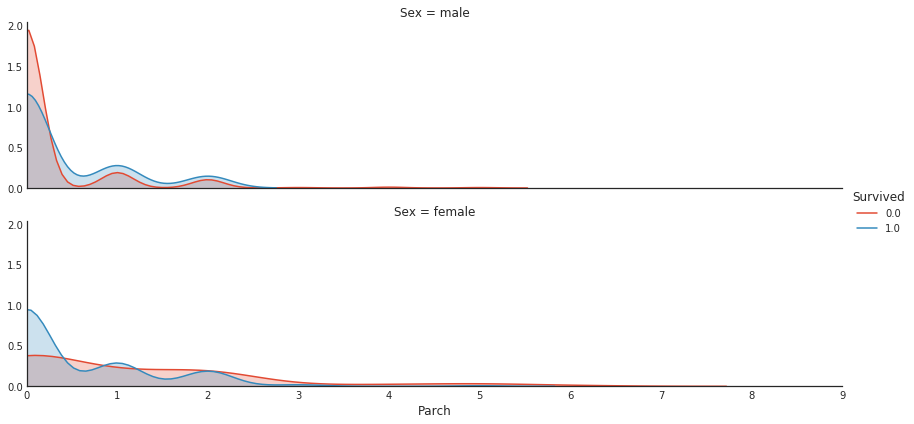

In [14]:
hlp.plot_distribution( X , var = 'Parch' , target = 'Survived' , row = 'Sex' )

In the above graphs we can see the importance of the distribution. If two curve (survived and not survived) are same then this feature won't help distinguish survived person. 

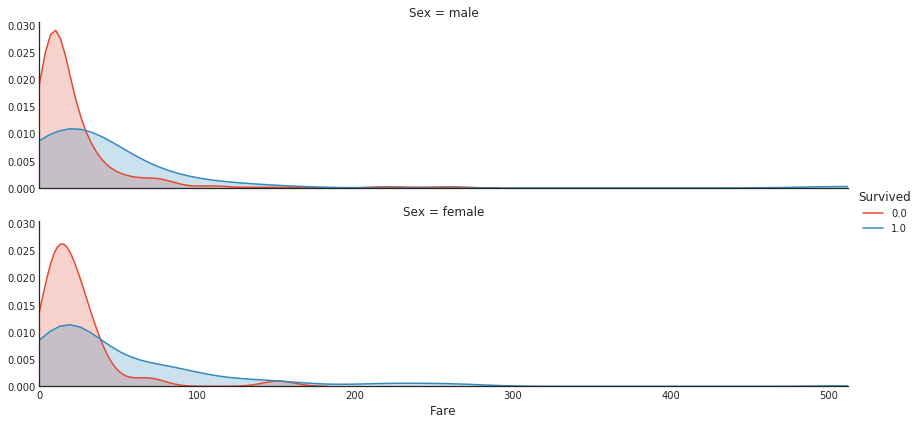

In [15]:
hlp.plot_distribution( X , var = 'Fare' , target = 'Survived' , row = 'Sex' )

In [ ]:
From the fare distribution we can see that fare feature is very important because the 
difference is shown in the graph.

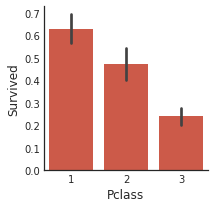

In [17]:
hlp.plot_categories( X , cat = 'Pclass' , target = 'Survived' )

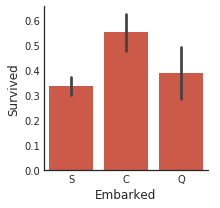

In [18]:
hlp.plot_categories( X , cat = 'Embarked' , target = 'Survived' )

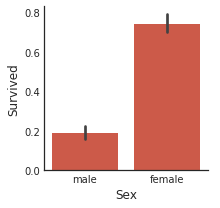

In [19]:
hlp.plot_categories( X , cat = 'Sex' , target = 'Survived' )

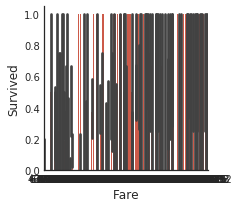

In [21]:
hlp.plot_categories( X , cat = 'Fare' , target = 'Survived' )

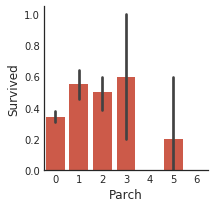

In [22]:
hlp.plot_categories( X , cat = 'Parch' , target = 'Survived' )

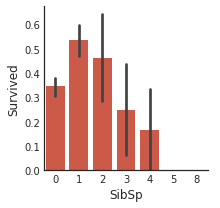

In [23]:
hlp.plot_categories( X , cat = 'SibSp' , target = 'Survived' )

In [ ]:
hlp.plot_categories( X , cat = 'SibSp' , target = 'Survived' )